<a href="https://colab.research.google.com/github/BLOOMFLARK/NN_noise_classification/blob/master/PCANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn.functional as F
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models, datasets

import random

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
class PCANet(torch.nn.Module):
    def __init__(self, num_filters: list, filters_sizes: list, batch_size=256):
        super(PCANet, self).__init__()
        self.params = {
            'num_filters': num_filters,
            'filters_sizes': filters_sizes,
        }
        self.W_1 = None
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act1 = torch.nn.ReLU()
        self.W_2 = None
        # self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = torch.nn.Linear(968, 2, bias=True)
        #self.fc = torch.nn.Linear(30250, 2, bias=True)
        # self.fc2 = torch.nn.Linear(100, 2, bias=True)
        self.batch_size = batch_size

    def forward(self, x):
        x = F.conv2d(x, self.W_1)
        #x = self.act1(x)
        x = self.pool1(x)
        N1, C1, H1, W1 = x.shape

        x = F.conv2d(x, self.W_2)
        #x = self.act1(x)
        x = self.pool1(x)
        N, C, H, W = x.shape

        x_flat = x.view(N, C * H * W)

        x_flat = self.fc(x_flat)
        # x_flat = self.act1(x_flat)
        # x_flat = self.fc2(x_flat)
        return x_flat
            
    @staticmethod        
    def _extract_image_patches(imgs: torch.Tensor, filter_size, stride=1, remove_mean=True):
        # imgs.shape = (N, C, H, W) -> (N, 1, H, W) 
        # так должно быть, но сюда могут прийти не grayscale изображения первого шага, а со второго
        # на котором применено L1 фильтров -> L1 каналов
        N, n_channels, H, W = imgs.shape
        stride=1
        
        if n_channels > 1:
            # изображение вида (N, C, H, W) - N C-канальных изображений
            # приводим к виду (N*C, 1, H, W) - N*C одно-канальных изображений
            imgs = imgs.view(-1, 1, H, W)
        print('images shape', imgs.shape)
            
        k = filter_size
        pad = tuple([k // 2 for i in range(4)]) # (k//2 , k//2, k//2, k//2)
        imgs_padded = torch.nn.functional.pad(imgs, pad=pad, mode='constant', value=0)

        patches = (imgs_padded.unfold(1 + 1, k, stride).unfold(1 + 2, k, stride)) # (N, C, H, W, k, k)
        patches = patches.flatten(1 + 1, 1 + 2).flatten(-2) # (N, 1, H*W, k^2)
        patches = patches.squeeze(1) # (N, H*W, k^2)

        print('patches_shape, ', patches.shape)
        print('should be patches shape, ', (imgs.shape[0], H*W, k**2))
        
        if remove_mean:
            patches -= patches.mean(dim=2, keepdim=True) # последнее измерение - патч
        
        print('filter_size', k)
        X = patches.view(-1, k**2) # (N*H*W, k^2)

        return X.permute(1, 0) # (k^2, N*H*W)

    
    def _convolve(self, imgs: torch.Tensor, filter_bank: torch.Tensor) -> torch.Tensor:
        weight = filter_bank
        output = F.conv2d(imgs, weight, padding=1)
        return output
    
    def _first_stage(self, imgs: torch.Tensor, train: bool) -> torch.Tensor:
        # (N, C, H, W) image
        # (train_size, 1, H, W) - grayscale
        assert imgs.dim() == 4 and imgs.nelement() > 0

        print('PCANet first stage...')

        if train:
            # достаем все патчи из всех N изображений
            filter_size1 = self.params['filters_sizes'][0]
            X = self._extract_image_patches(
                imgs, filter_size1)
            
            n_filters = self.params['num_filters'][0]
            
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters, batch_size=self.batch_size)
            self.W_1 = torch.FloatTensor(eigenvectors).view(n_filters, 1, filter_size1, filter_size1)
         
        I = self._convolve(imgs, self.W_1)  # (N, 1, H, W) * (L1, k1, k1) -> (N, L1, H', W')
        return I
    
    @staticmethod
    def conv_output_size(w, filter_size, padding=1, stride=1):
        return int((w - filter_size + 2 * padding) / stride + 1)
    
    @staticmethod
    def get_pca_eigenvectors(X, n_components, batch_size=100):
        ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
        print('pca fitting ...')
        ipca.fit(X @ X.t())
        eigenvectors = ipca.components_
        print('eigenvectors shape:', eigenvectors.shape)
        return eigenvectors
        
    def _second_stage(self, I: torch.Tensor, train):
        print('PCANet second stage...')
        # I: (N, L1, H, W)
        if train:
            N, L1, H, W = I.shape
            filter_size2 = self.params['filters_sizes'][1]
            n_filters2 = self.params['num_filters'][1]
            n_filters1 = self.params['num_filters'][0]
            
            H_new = self.conv_output_size(I.shape[2], filter_size2)
            W_new = self.conv_output_size(I.shape[3], filter_size2)
            
            X = self._extract_image_patches(I, filter_size2)

            print('X_SHAPE ', X.shape)
            print(H_new, W_new)

            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters2, batch_size=self.batch_size)
            
            W_2 = torch.FloatTensor(eigenvectors).view(n_filters2, 1, filter_size2, filter_size2) # (L2, 1, k2, k2)
            self.W_2 = W_2.repeat(1, n_filters1, 1, 1) # (L2, L1, k2, k2) - повторяет L1 раз для конкретного l из L2

        return self._convolve(I, self.W_2)
    
    def run(self, images):
        # Создаем фильтры
        # images: (N, 1, H, W)
        I = self._first_stage(images, train=True)
        print("I ", I.shape)
        II = self._second_stage(I, train=True)

    def fit(self, loss, optimizer, device, train_data, test_data, num_epochs=100):
        self.val_loss = np.zeros(num_epochs)
        self.train_loss = np.zeros(num_epochs)

        self.val_acc = np.zeros(num_epochs)
        self.train_acc = np.zeros(num_epochs)

        if self.W_1 is None or self.W_2 is None:
            self.run(X_train)
        
        self.W_1 = self.W_1.to(device)
        self.W_2 = self.W_2.to(device)

        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    #data = train_data
                    data = train_data
                    self.train()  # training mode
                    history_acc = self.train_acc
                    history_loss = self.train_loss
                else:
                    #data = test_data
                    data = test_data
                    self.eval()   # evaluate mode (dropout + bn)
                    history_acc = self.val_acc
                    history_loss = self.val_loss

                running_loss = 0.
                running_acc = 0.

                # Iterate over data.
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = self(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.cpu().item()
                running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()
            
                epoch_loss = running_loss
                epoch_acc = running_acc
                history_acc[epoch] = epoch_acc
                history_loss[epoch] = epoch_loss

                # запоминаем модель по лоссу

                print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)
    
    def plot_loss(self):
        num_epochs = self.train_loss.shape[0]
        # Loss
        plt.plot(range(num_epochs), self.train_loss, self.val_loss)
        plt.legend(['train', 'val'])
        plt.xlabel('epoch')
        plt.ylabel('cross entropy loss')
        plt.title('loss')

    def plot_acc(self):
        num_epochs = self.train_acc.shape[0]
        # Loss
        plt.plot(range(num_epochs), self.train_acc, self.val_acc)
        plt.legend(['train', 'val'])
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('accuracy')
        
        
        

In [12]:
net = PCANet([8, 8], [7, 7])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

cuda:0


In [5]:
net

PCANet(
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act1): ReLU()
  (fc): Linear(in_features=1440, out_features=2, bias=True)
)

In [0]:
batch_size = 150
lr = 1e-3

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [0]:
MNIST_train = datasets.MNIST('sample_data', train=True, transform=None, target_transform=None, download=True)
MNIST_test = datasets.MNIST('sample_data', train=False, transform=None, target_transform=None, download=True)

X_train = MNIST_train.data[:11000, :, :]
y_train = MNIST_train.targets[:11000]
X_test = MNIST_test.data[:1650, :, :]
y_test = MNIST_test.targets[:1650]

X_train = X_train.unsqueeze(1).float() # (11000, 1, 28, 28)
X_test = X_test.unsqueeze(1).float() # (1650, 1, 28, 28)

In [0]:
net.fit(loss,
        optimizer,
        device,
        train_data=(X_train, y_train),
        test_data=(X_test, y_test),
        num_epochs=500)

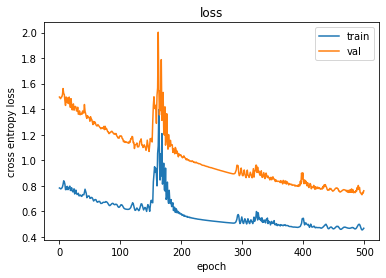

In [0]:
net.plot_loss()

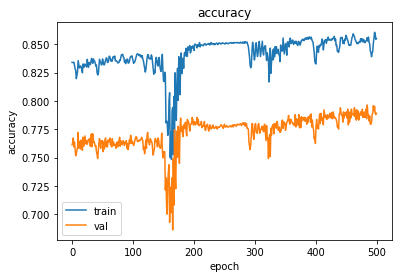

In [0]:
net.plot_acc()

In [0]:
data_root = 'drive/My Drive/dl_noise_classification/data/'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
class_names = ['awgn', 'bayer']

train_dir = os.path.join(data_root, train_dir)
val_dir = os.path.join(data_root, val_dir)
test_dir = os.path.join(data_root, test_dir)

In [9]:
# МНОГО ПРОЦЕССОВ ЖРУТ ПАМЯТЬ ОЧЕНЬ МНОГО, при этом сильно не ускоряют
train_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    #transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    #transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)
#test_dataset = datasets.ImageFolder(test_dir, train_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)
#test_size = len(test_dataset)

all_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_size, shuffle=False, num_workers=batch_size)

#train_dataloader = torch.utils.data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

#val_dataloader = torch.utils.data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

all_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_size, shuffle=False, num_workers=val_size)

#all_test = torch.utils.data.DataLoader(
#    test_dataset, batch_size=train_size, shuffle=False, num_workers=test_size)
print("TRAIN_SIZE: {}\n VAL_SIZE: {}\n".format(train_size, val_size))#, #test_size))

TRAIN_SIZE: 1200
 VAL_SIZE: 400



In [10]:
%%time
#print('all val data loading ...')
#val_data = next(iter(all_val))
print('all train data loading ...')
train_data = next(iter(all_train))
#print('test data loading')
#test_data = next(iter(all_test))

all train data loading ...
CPU times: user 521 ms, sys: 3.27 s, total: 3.79 s
Wall time: 15min 18s


In [11]:
%%time

print(train_data[0].shape, train_data[1].shape)
torch.save(train_data, 'drive/My Drive/dl_noise_classification/data/tensor_images64x64.pth')

torch.Size([1200, 1, 64, 64]) torch.Size([1200])
CPU times: user 5.4 ms, sys: 9.04 ms, total: 14.4 ms
Wall time: 45.9 ms


In [13]:
%%time

print('all val data loading ...')
val_data = next(iter(all_val))

all val data loading ...
CPU times: user 916 ms, sys: 10.5 s, total: 11.4 s
Wall time: 5min 23s


In [0]:
torch.save(val_data, 'drive/My Drive/dl_noise_classification/data/tensor_images64x64_val.pth')

In [8]:
%%time
train_data = torch.load('drive/My Drive/dl_noise_classification/data/tensor_images64x64.pth')
val_data = torch.load('drive/My Drive/dl_noise_classification/data/tensor_images64x64_val.pth')

CPU times: user 3.93 ms, sys: 22 ms, total: 26 ms
Wall time: 38.5 ms


In [0]:
X_train, y_train = train_data
X_test, y_test = val_data

In [15]:
net.fit(loss,
        optimizer,
        device,
        train_data=(X_train, y_train),
        test_data=(X_test, y_test),
        num_epochs=500)

Epoch 0/499:
train Loss: 0.8813 Acc: 0.4983

val Loss: 0.8463 Acc: 0.5000

Epoch 1/499:
train Loss: 0.8111 Acc: 0.5117

val Loss: 0.8756 Acc: 0.4975

Epoch 2/499:
train Loss: 0.7513 Acc: 0.5092

val Loss: 0.8964 Acc: 0.4700

Epoch 3/499:
train Loss: 0.7309 Acc: 0.5225

val Loss: 0.8662 Acc: 0.4800

Epoch 4/499:
train Loss: 0.7104 Acc: 0.5092

val Loss: 0.8395 Acc: 0.4925

Epoch 5/499:
train Loss: 0.7086 Acc: 0.5183

val Loss: 0.8367 Acc: 0.4900

Epoch 6/499:
train Loss: 0.7054 Acc: 0.5242

val Loss: 0.8490 Acc: 0.4500

Epoch 7/499:
train Loss: 0.6999 Acc: 0.5258

val Loss: 0.8596 Acc: 0.4400

Epoch 8/499:
train Loss: 0.7004 Acc: 0.5433

val Loss: 0.8513 Acc: 0.4500

Epoch 9/499:
train Loss: 0.6967 Acc: 0.5483

val Loss: 0.8349 Acc: 0.4525

Epoch 10/499:
train Loss: 0.6932 Acc: 0.5500

val Loss: 0.8256 Acc: 0.4450

Epoch 11/499:
train Loss: 0.6924 Acc: 0.5292

val Loss: 0.8256 Acc: 0.4450

Epoch 12/499:
train Loss: 0.6878 Acc: 0.5375

val Loss: 0.8317 Acc: 0.4650

Epoch 13/499:
train Lo

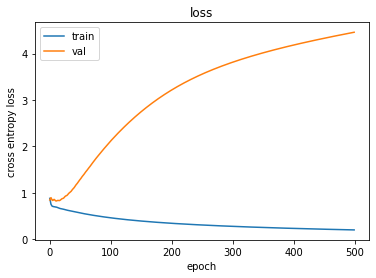

In [16]:
net.plot_loss()

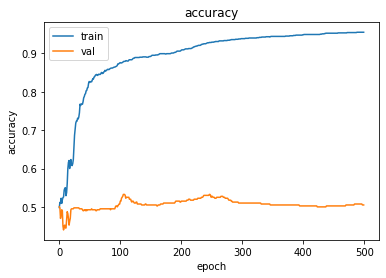

In [17]:
net.plot_acc()